# Tugas Mandiri 4 - Logistic Regression
## Prediksi Pembelian Mobil

## 1. Import Library dan Load Data

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

df = pd.read_csv('../../Data/calonpembelimobil.csv')
df.head()

,ID,Usia,Status,Kelamin,Memiliki_Mobil,Penghasilan,Beli_Mobil
0,1,32,1,0,0,240,1
1,2,49,2,1,1,100,0
2,3,52,1,0,2,250,1
3,4,26,2,1,1,130,0
4,5,45,3,0,2,237,1


In [18]:
corr_matrix = df.corr()

### 2. Visualisasi Heatmap Korelasi

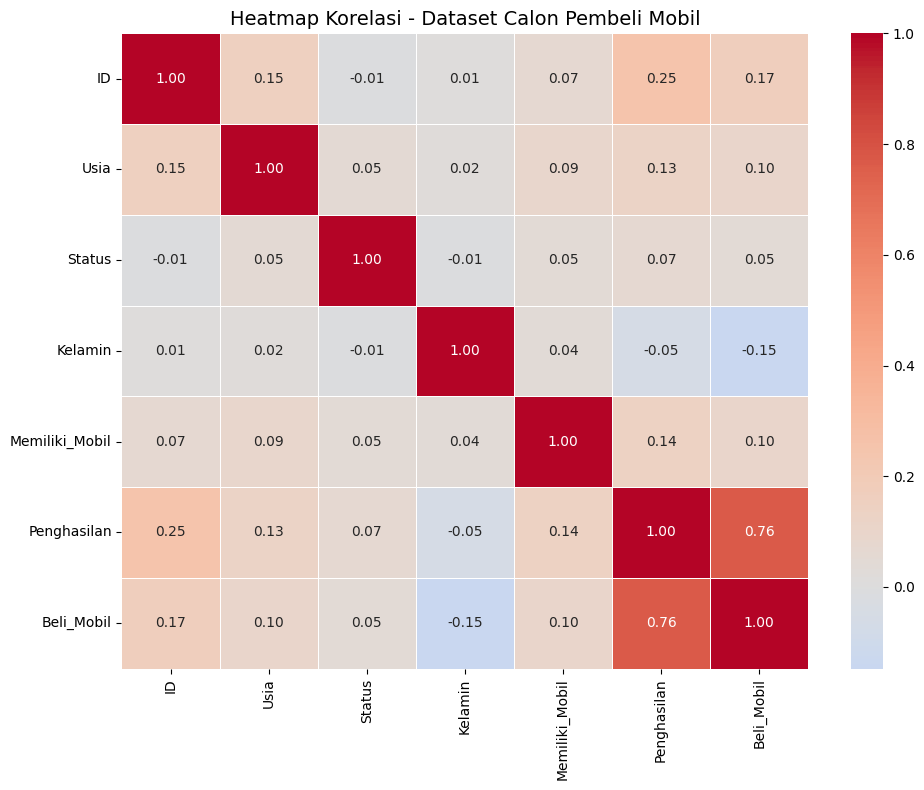

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    center=0
)
plt.title("Heatmap Korelasi - Dataset Calon Pembeli Mobil", fontsize=14)
plt.tight_layout()
plt.show()

## 3. Menentukan Fitur dan Target

In [20]:
# Fitur untuk prediksi
X = df[['Usia', 'Status', 'Kelamin', 'Penghasilan', 'Memiliki_Mobil']]
y = df['Beli_Mobil']

print("X shape:", X.shape)
print("y shape:", y.shape)
print("\nDistribusi Target (Beli_Mobil):")
print(y.value_counts())

X shape: (1000, 5)
y shape: (1000,)

Distribusi Target (Beli_Mobil):
Beli_Mobil
1    633
0    367
Name: count, dtype: int64


## 4. Membagi Dataset menjadi Training dan Testing Set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (800, 5)
Data uji: (200, 5)


## 5. Pembangunan Model Logistic Regression

In [23]:
# Definisikan fitur numerik
feature_num = ['Usia', 'Penghasilan']
feature_bin = ['Status', 'Kelamin', 'Memiliki_Mobil']

# Preprocessing: scale fitur numerik, passthrough untuk fitur biner
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

# Model Logistic Regression
model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

# Pipeline: preprocessing + model
clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

# Latih model
clf.fit(X_train, y_train)
print("✔ Model Logistic Regression berhasil dilatih.")

✔ Model Logistic Regression berhasil dilatih.


## 6. Prediksi Data Baru (Contoh Kasus)

In [ ]:
# Contoh 3 calon pembeli
data_baru = pd.DataFrame({
    'Usia': [35, 28, 45],
    'Status': [2, 1, 3],           # 1=Single, 2=Menikah, 3=Janda / Duda
    'Kelamin': [1, 0, 1],          # 1=Laki-laki, 0=Perempuan
    'Penghasilan': [250, 120, 300],
    'Memiliki_Mobil': [0, 1, 2]    # Jumlah mobil yang dimiliki
})

# Prediksi
pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:, 1]

# Hasil
hasil = data_baru.copy()
hasil['Probabilitas_Beli'] = prob
hasil['Prediksi (0=Tidak, 1=Ya)'] = pred

print("\nPREDIKSI CALON PEMBELI MOBIL")
print("="*80)
display(hasil)
print("="*80)


PREDIKSI CALON PEMBELI MOBIL


,Usia,Status,Kelamin,Penghasilan,Memiliki_Mobil,Probabilitas_Beli,"Prediksi (0=Tidak, 1=Ya)"
0,35,2,1,250,0,0.548695,1
1,28,1,0,120,1,0.009216,0
2,45,3,1,300,2,0.932633,1


## 7. Interpretasi Model (Koefisien & Odds Ratio)

In [34]:
# Ambil nama fitur & koefisien
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

# Buat DataFrame untuk interpretasi
coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'Koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

print("\nINTERPRETASI KOEFISIEN MODEL")
print("="*60)
display(coef_df)
print("="*60)
print("\nPenjelasan:")
print("- Odds Ratio > 1: Meningkatkan kemungkinan membeli mobil")
print("- Odds Ratio < 1: Menurunkan kemungkinan membeli mobil")
print("- Odds Ratio = 1: Tidak ada pengaruh")


INTERPRETASI KOEFISIEN MODEL


,Fitur,Koefisien (log-odds),Odds Ratio (e^coef)
1,Penghasilan,4.550296,94.660404
4,Memiliki_Mobil,0.094958,1.099613
0,Usia,-0.046660,0.954412
2,Status,-0.124292,0.883122
3,Kelamin,-1.130837,0.322763



Penjelasan:
- Odds Ratio > 1: Meningkatkan kemungkinan membeli mobil
- Odds Ratio < 1: Menurunkan kemungkinan membeli mobil
- Odds Ratio = 1: Tidak ada pengaruh


## 8. Cross-Validation

In [35]:
# Lakukan cross-validation (5-fold)
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

print("="*50)
print("CROSS-VALIDATION (5-FOLD)")
print("="*50)
print("Skor tiap fold:", scores)
print(f"Rata-rata akurasi: {np.mean(scores):.4f}")
print(f"Standar deviasi: {np.std(scores):.4f}")
print("="*50)

CROSS-VALIDATION (5-FOLD)
Skor tiap fold: [0.775 0.915 0.955 0.945 0.94 ]
Rata-rata akurasi: 0.9060
Standar deviasi: 0.0668


## 9. Classification Report

In [37]:
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(
    y_test, y_pred, 
    target_names=['Tidak Beli (0)', 'Beli (1)'], 
    zero_division=0
))
print("="*60)

CLASSIFICATION REPORT
                precision    recall  f1-score   support

Tidak Beli (0)       0.86      0.97      0.91        73
      Beli (1)       0.98      0.91      0.94       127

      accuracy                           0.93       200
     macro avg       0.92      0.94      0.93       200
  weighted avg       0.94      0.93      0.93       200



## 10. ROC Curve

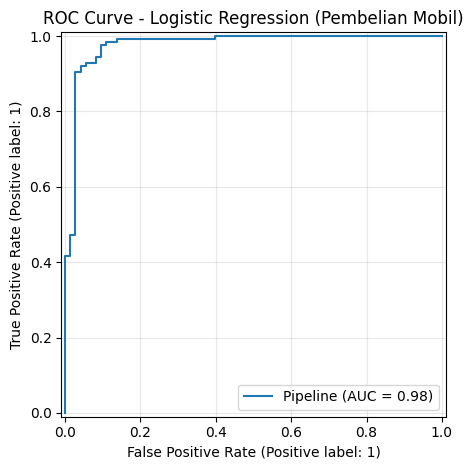

In [38]:
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve - Logistic Regression (Pembelian Mobil)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Confusion Matrix

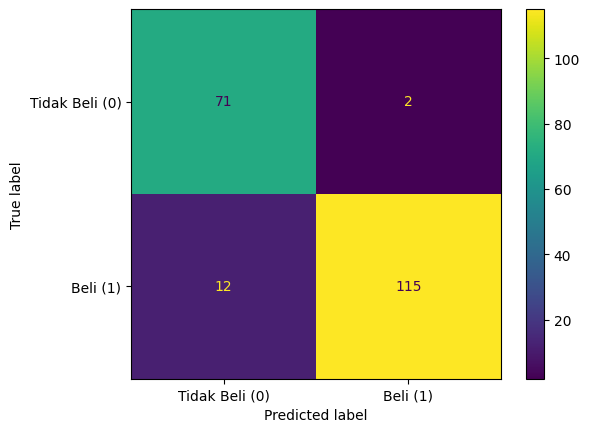

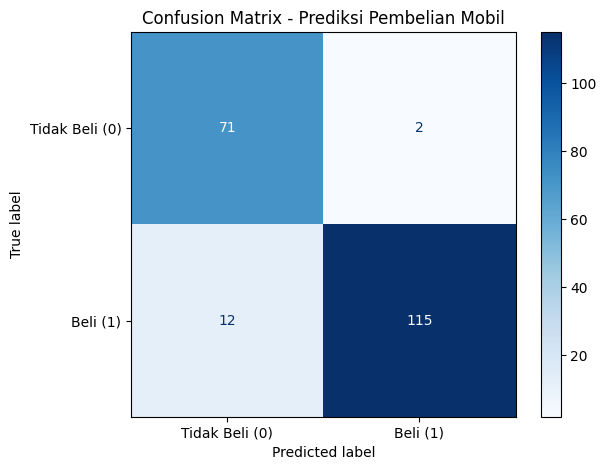

In [39]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=['Tidak Beli (0)', 'Beli (1)']
).plot(values_format='d', cmap='Blues')
plt.title("Confusion Matrix - Prediksi Pembelian Mobil")
plt.tight_layout()
plt.show()

## 12. Prediksi dan Evaluasi Model

In [40]:
# Prediksi & probabilitas
y_pred = clf.predict(X_test)               # label kelas (0/1)
y_prob = clf.predict_proba(X_test)[:, 1]  # probabilitas kelas positif (1)

# Hitung metrik evaluasi
print("="*50)
print("EVALUASI MODEL LOGISTIC REGRESSION")
print("="*50)
print(f"Akurasi   : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score  : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC   : {roc_auc_score(y_test, y_prob):.4f}")
print("="*50)

EVALUASI MODEL LOGISTIC REGRESSION
Akurasi   : 0.9300
Precision : 0.9829
Recall    : 0.9055
F1-Score  : 0.9426
ROC-AUC   : 0.9769
